In [1]:
try:
    import qiskit
except (ImportError):
    %pip install qiskit ipywidgets
    import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
#from qiskit.primitives 
from qiskit import IBMQ, Aer, transpile, assemble
import math
import random
import numpy as np
from scipy.optimize import minimize
try:
    import matplotlib.pyplot as plt
except (ImportError):
    %pip install matplotlib
    import matplotlib.pyplot as plt
import qiskit.tools.jupyter
from qiskit_ibm_provider import IBMProvider
from qiskit.providers.aer.noise import NoiseModel

try:
    from qiskit_ionq import IonQProvider, ErrorMitigation
except (ImportError):
    %pip install qiskit-ionq
    from qiskit_ionq import IonQProvider, ErrorMitigation

f = open("C:\\Users\\fouad\\Documents\\tokens.txt", "r")
next = f.readline()
TOKEN = next[:len(next)-1]
next = f.readline()
TOKEN_IONQ = next[:len(next)-1]

NOISE = True
IONQ = False

if IONQ:
    provider = IonQProvider(TOKEN_IONQ)
    backend = provider.get_backend('ionq_simulator')
else:
    #IBMProvider.save_account(token=TOKEN)
    provider = IBMProvider()
    if NOISE:
        noise = provider.get_backend('ibmq_manila')
        noise_model = NoiseModel.from_backend(noise)
        backend = Aer.get_backend('aer_simulator', noise_model=noise_model)
    else:
        backend = Aer.get_backend('aer_simulator')

In [2]:
def apply_fixed_ansatz(qubits, parameters):

    for iz in range (0, len(qubits)):
        circ.ry(parameters[0][iz], qubits[iz])

    circ.cz(qubits[0], qubits[1])
    circ.cz(qubits[2], qubits[0])

    for iz in range (0, len(qubits)):
        circ.ry(parameters[1][iz], qubits[iz])

    circ.cz(qubits[1], qubits[2])
    circ.cz(qubits[2], qubits[0])

    for iz in range (0, len(qubits)):
        circ.ry(parameters[2][iz], qubits[iz])

circ = QuantumCircuit(3)
apply_fixed_ansatz([0, 1, 2], [ [1, 1, 1], [1, 1, 1], [1, 1, 1] ])
circ.draw()

┌───────┐      ┌───────┐      ┌───────┐
q_0: ┤ Ry(1) ├─■──■─┤ Ry(1) ├────■─┤ Ry(1) ├
     ├───────┤ │  │ ├───────┤    │ ├───────┤
q_1: ┤ Ry(1) ├─■──┼─┤ Ry(1) ├─■──┼─┤ Ry(1) ├
     ├───────┤    │ ├───────┤ │  │ ├───────┤
q_2: ┤ Ry(1) ├────■─┤ Ry(1) ├─■──■─┤ Ry(1) ├
     └───────┘      └───────┘      └───────┘

In [3]:
# Creates the Hadamard test

def had_test(gate_type, qubits, auxiliary_index, parameters):

    circ.h(auxiliary_index)

    apply_fixed_ansatz(qubits, parameters)

    for ie in range (0, len(gate_type[0])):
        if (gate_type[0][ie] == 1):
            circ.cz(auxiliary_index, qubits[ie])

    for ie in range (0, len(gate_type[1])):
        if (gate_type[1][ie] == 1):
            circ.cz(auxiliary_index, qubits[ie])
    
    circ.h(auxiliary_index)
    
circ = QuantumCircuit(4)
had_test([ [0, 0, 0], [0, 0, 1] ], [1, 2, 3], 0, [ [1, 1, 1], [1, 1, 1], [1, 1, 1] ])
circ.draw()

┌───┐                                   ┌───┐
q_0: ──┤ H ├─────────────────────────────────■─┤ H ├
     ┌─┴───┴─┐      ┌───────┐      ┌───────┐ │ └───┘
q_1: ┤ Ry(1) ├─■──■─┤ Ry(1) ├────■─┤ Ry(1) ├─┼──────
     ├───────┤ │  │ ├───────┤    │ ├───────┤ │      
q_2: ┤ Ry(1) ├─■──┼─┤ Ry(1) ├─■──┼─┤ Ry(1) ├─┼──────
     ├───────┤    │ ├───────┤ │  │ ├───────┤ │      
q_3: ┤ Ry(1) ├────■─┤ Ry(1) ├─■──■─┤ Ry(1) ├─■──────
     └───────┘      └───────┘      └───────┘

In [4]:
# Creates controlled anstaz for calculating |<b|psi>|^2 with a Hadamard test

def control_fixed_ansatz(qubits, parameters, auxiliary, reg):

    for i in range (0, len(qubits)):
        circ.cry(parameters[0][i], qiskit.circuit.Qubit(reg, auxiliary), qiskit.circuit.Qubit(reg, qubits[i]))

    circ.ccx(auxiliary, qubits[1], 4)
    circ.cz(qubits[0], 4)
    circ.ccx(auxiliary, qubits[1], 4)

    circ.ccx(auxiliary, qubits[0], 4)
    circ.cz(qubits[2], 4)
    circ.ccx(auxiliary, qubits[0], 4)

    for i in range (0, len(qubits)):
        circ.cry(parameters[1][i], qiskit.circuit.Qubit(reg, auxiliary), qiskit.circuit.Qubit(reg, qubits[i]))

    circ.ccx(auxiliary, qubits[2], 4)
    circ.cz(qubits[1], 4)
    circ.ccx(auxiliary, qubits[2], 4)

    circ.ccx(auxiliary, qubits[0], 4)
    circ.cz(qubits[2], 4)
    circ.ccx(auxiliary, qubits[0], 4)

    for i in range (0, len(qubits)):
        circ.cry(parameters[2][i], qiskit.circuit.Qubit(reg, auxiliary), qiskit.circuit.Qubit(reg, qubits[i]))

q_reg = QuantumRegister(5)
circ = QuantumCircuit(q_reg)
control_fixed_ansatz([1, 2, 3], [ [1, 1, 1], [1, 1, 1], [1, 1, 1] ], 0, q_reg)
circ.draw()

»
q0_0: ────■────────■────────■──────■───────■────■───────■──────■────────■────»
      ┌───┴───┐    │        │      │       │    │       │  ┌───┴───┐    │    »
q0_1: ┤ Ry(1) ├────┼────────┼──────┼───■───┼────■───────■──┤ Ry(1) ├────┼────»
      └───────┘┌───┴───┐    │      │   │   │    │       │  └───────┘┌───┴───┐»
q0_2: ─────────┤ Ry(1) ├────┼──────■───┼───■────┼───────┼───────────┤ Ry(1) ├»
               └───────┘┌───┴───┐  │   │   │    │       │           └───────┘»
q0_3: ──────────────────┤ Ry(1) ├──┼───┼───┼────┼───■───┼────────────────────»
                        └───────┘┌─┴─┐ │ ┌─┴─┐┌─┴─┐ │ ┌─┴─┐                  »
q0_4: ───────────────────────────┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├──────────────────»
                                 └───┘   └───┘└───┘   └───┘                  »
«                                                                    
«q0_0: ────■──────■───────■────■───────■──────■────────■────────■────
«          │      │       │    │       │  ┌───┴───┐    │        │    
«q0_1: ────┼──────┼───────┼────■───────■──┤ Ry(1) ├────┼────────┼────
«          │      │       │    │       │  └───────┘┌───┴───┐    │    
«q0_2: ────┼──────┼───■───┼────┼───────┼───────────┤ Ry(1) ├────┼────
«      ┌───┴───┐  │   │   │    │       │           └───────┘┌───┴───┐
«q0_3: ┤ Ry(1) ├──■───┼───■────┼───■───┼────────────────────┤ Ry(1) ├
«      └───────┘┌─┴─┐ │ ┌─┴─┐┌─┴─┐ │ ┌─┴─┐                  └───────┘
«q0_4: ─────────┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├───────────────────────────
«               └───┘   └───┘└───┘   └───┘

In [5]:
def control_b(auxiliary, qubits):

    for ia in qubits:
        circ.ch(auxiliary, ia)

circ = QuantumCircuit(4)
control_b(0, [1, 2, 3])
circ.draw()

q_0: ──■────■────■──
     ┌─┴─┐  │    │  
q_1: ┤ H ├──┼────┼──
     └───┘┌─┴─┐  │  
q_2: ─────┤ H ├──┼──
          └───┘┌─┴─┐
q_3: ──────────┤ H ├
               └───┘

In [6]:
# Create the controlled Hadamard test, for calculating <psi|psi>

def special_had_test(gate_type, qubits, auxiliary_index, parameters, reg):

    circ.h(auxiliary_index)

    control_fixed_ansatz(qubits, parameters, auxiliary_index, reg)

    for ty in range (0, len(gate_type)):
        if (gate_type[ty] == 1):
            circ.cz(auxiliary_index, qubits[ty])


    control_b(auxiliary_index, qubits)
    
    circ.h(auxiliary_index)

q_reg = QuantumRegister(5)
circ = QuantumCircuit(q_reg)
special_had_test([ [0, 0, 0], [0, 0, 1] ], [1, 2, 3], 0, [ [1, 1, 1], [1, 1, 1], [1, 1, 1] ], q_reg)
circ.draw()

┌───┐                                                              »
q1_0: ┤ H ├────■────────■────────■──────■───────■────■───────■──────■────»
      └───┘┌───┴───┐    │        │      │       │    │       │  ┌───┴───┐»
q1_1: ─────┤ Ry(1) ├────┼────────┼──────┼───■───┼────■───────■──┤ Ry(1) ├»
           └───────┘┌───┴───┐    │      │   │   │    │       │  └───────┘»
q1_2: ──────────────┤ Ry(1) ├────┼──────■───┼───■────┼───────┼───────────»
                    └───────┘┌───┴───┐  │   │   │    │       │           »
q1_3: ───────────────────────┤ Ry(1) ├──┼───┼───┼────┼───■───┼───────────»
                             └───────┘┌─┴─┐ │ ┌─┴─┐┌─┴─┐ │ ┌─┴─┐         »
q1_4: ────────────────────────────────┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├─────────»
                                      └───┘   └───┘└───┘   └───┘         »
«                                                                             »
«q1_0: ────■────────■──────■───────■────■───────■──────■────────■────────■────»
«          │        │      │       │    │       │  ┌───┴───┐    │        │    »
«q1_1: ────┼────────┼──────┼───────┼────■───────■──┤ Ry(1) ├────┼────────┼────»
«      ┌───┴───┐    │      │       │    │       │  └───────┘┌───┴───┐    │    »
«q1_2: ┤ Ry(1) ├────┼──────┼───■───┼────┼───────┼───────────┤ Ry(1) ├────┼────»
«      └───────┘┌───┴───┐  │   │   │    │       │           └───────┘┌───┴───┐»
«q1_3: ─────────┤ Ry(1) ├──■───┼───■────┼───■───┼────────────────────┤ Ry(1) ├»
«               └───────┘┌─┴─┐ │ ┌─┴─┐┌─┴─┐ │ ┌─┴─┐                  └───────┘»
«q1_4: ──────────────────┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├───────────────────────────»
«                        └───┘   └───┘└───┘   └───┘                           »
«                     ┌───┐
«q1_0: ──■────■────■──┤ H ├
«      ┌─┴─┐  │    │  └───┘
«q1_1: ┤ H ├──┼────┼───────
«      └───┘┌─┴─┐  │       
«q1_2: ─────┤ H ├──┼───────
«           └───┘┌─┴─┐     
«q1_3: ──────────┤ H ├─────
«                └───┘     
«q1_4: ────────────────────
«

In [7]:
# Implements the entire cost function on the quantum circuit


def calculate_cost_function(parameters):
  
    global opt,current_cost, my_params

    my_params = parameters
    overall_sum_1 = 0
    
    parameters = [parameters[0:3], parameters[3:6], parameters[6:9] ]

    for i in range(0, len(gate_set)):
        for j in range(0, len(gate_set)):

            global circ

            qctl = QuantumRegister(5)
            qc = ClassicalRegister(5)
            circ = QuantumCircuit(qctl, qc)

            
            multiply = coefficient_set[i]*coefficient_set[j]

            had_test([gate_set[i], gate_set[j] ], [1, 2, 3], 0, parameters)

            circ.save_statevector()

            t_circ = transpile(circ, backend)

            qobj = assemble(t_circ)
            

            job = backend.run(qobj)
            
            result = job.result()

            outputstate = np.real(result.get_statevector(circ, decimals=100))
            o = outputstate

            
            m_sum = 0
            for l in range (0, o.size):
                if (l%2 == 1):
                    n = o[l]**2
                    m_sum+=n

            overall_sum_1+=multiply*(1-(2*m_sum))

    overall_sum_2 = 0

    for i in range(0, len(gate_set)):
        for j in range(0, len(gate_set)):

            multiply = coefficient_set[i]*coefficient_set[j]
            mult = 1

            for extra in range(0, 2):

                qctl = QuantumRegister(5)
                qc = ClassicalRegister(5)
                circ = QuantumCircuit(qctl, qc)


                if (extra == 0):
                    special_had_test(gate_set[i], [1, 2, 3], 0, parameters, qctl)
                if (extra == 1):
                    special_had_test(gate_set[j], [1, 2, 3], 0, parameters, qctl)

                circ.save_statevector()
                
                t_circ = transpile(circ, backend)
                
                qobj = assemble(t_circ)
                
                job = backend.run(qobj, )
                  
                result = job.result()

                outputstate = np.real(result.get_statevector(circ, decimals=100))
                o = outputstate

                m_sum = 0
                for l in range (0, o.size):
                    if (l%2 == 1):
                        n = o[l]**2
                        m_sum+=n
                
                mult = mult*(1-(2*m_sum))

            overall_sum_2+=multiply*mult
            
    print(1-float(overall_sum_2/overall_sum_1))
    current_cost = 1-float(overall_sum_2/overall_sum_1)

    #return 1-float(overall_sum_2/overall_sum_1)
    return current_cost

In [8]:
# creating and storing random k, for later reproduceability
k  = [float(random.randint(0,3000))/1000 for i in range(0, 9)]

In [9]:
def log_cost(x):
  cost_values.append(current_cost)
  res_params.append(my_params)

optimizers = ["COBYLA", "CG", "BFGS", "L-BFGS-B", "SLSQP", ]

coefficient_set = [0.55, 0.45]
gate_set = [ [0, 0, 0], [0, 0, 1] ]

max_iter = 200
cost_sum = np.zeros((len(optimizers), max_iter+1))
all_params = []
opt_iter = 1
nqubits = 3
anci_bits = 3

accuracy = []

for j in range(opt_iter):
  for i in range(len(optimizers)):
    cost_values = [] 
    res_params = []
    out = minimize(calculate_cost_function, x0=k, method=optimizers[i], options={'maxiter':max_iter}, callback=log_cost)
    print(out)

    all_params += [res_params]
    proper_index = 0
    for element in np.array(cost_values):
      cost_sum[i][proper_index] += element
      proper_index += 1
    
    out_f = [out['x'][0:3], out['x'][3:6], out['x'][6:9] ]

    circ = QuantumCircuit(nqubits, anci_bits)
    apply_fixed_ansatz([0, 1, 2], out_f)

    circ.save_statevector()

    t_circ = transpile(circ, backend)
    qobj = assemble(t_circ)
    job = backend.run(qobj)

    result = job.result()
    o = result.get_statevector(circ, decimals=10)

    I = np.array([[1, 0], [0, 1]])
    Z = np.array([[1, 0], [0, -1]])
    a3 = np.zeros((8,8))
    for r in range(len(gate_set)):
      ad = []
      for f in range(len(gate_set[r])):
        ad += [I] if gate_set[r][f] == 0 else [Z]
      a3 = np.add(a3, coefficient_set[r] * np.kron(np.kron(ad[2], ad[1]), ad[0]))

    b = np.ones(2**nqubits)/np.sqrt(2**nqubits)

    accuracy_result = (b.dot(a3.dot(o)/(np.linalg.norm(a3.dot(o)))))**2
    print(accuracy_result)
    accuracy += [accuracy_result]


C:\Users\fouad\AppData\Local\Temp\ipykernel_14096\734511844.py:34: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = backend.run(qobj)
C:\Users\fouad\AppData\Local\Temp\ipykernel_14096\734511844.py:76: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = backend.run(qobj, )


0.774021018289416
0.7147984341140081
0.6064997992451809
0.7083168661823661
0.9665749050910174
0.7405954428390433
0.5092059044195241
0.6613588924747497
0.6041323347894652
0.5003298562564639
0.48307708345633904
0.5210070994879776
0.47496356609110013
0.512168567202052
0.4821991358527241
0.44677475917196763
0.4886769828420017
0.44585141746627444
0.5048694333647776
0.4408249511490542
0.5000396629243649
0.4394005774850973
0.4497866318959798
0.4298919557444132
0.43009227632740743
0.46459591200889017
0.44464633526432273
0.41899506399848707
0.4389916270664477
0.43987665047052016
0.3910702384846606
0.3831904629378996
0.37604081145652624
0.3458417156718362
0.3290160218838215
0.30262336810530865
0.2937184183389244
0.3338633247421008
0.3399183447657136
0.2255767455035511
0.26125442403831434
0.17131586206792015
0.2081295607275636
0.1418565180418606
0.2946329462247438
0.19712797245382319
0.349852353963225
0.1555608902698391
0.14632454017755658
0.18767622275367535
0.1412903966253315
0.1345034187897785

C:\Users\fouad\AppData\Local\Temp\ipykernel_14096\2946545881.py:41: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = backend.run(qobj)


0.774021018289416
0.7740210174524982
0.7740210156673819
0.774021016760438
0.7740210208974677
0.774021015662708
0.7740210158655061
0.7740210168384265
0.7740210209345311
0.7740210169796289
0.6145321260603855
0.614532125201525
0.6145321244203071
0.6145321253470748
0.6145321282851652
0.614532124422867
0.6145321245372515
0.6145321246018488
0.6145321276699546
0.6145321254688592
0.562169857010345
0.562169856614033
0.5621698591055737
0.5621698564473391
0.5621698573074481
0.5621698589427888
0.5621698563623228
0.5621698570392146
0.5621698548107978
0.5621698564142581
0.5370760098577183
0.5370760095520972
0.5370760116799422
0.5370760091405764
0.537076009683205
0.5370760115216658
0.5370760093205171
0.5370760103641079
0.5370760077870813
0.5370760091593136
0.5128444783857365
0.5128444781013857
0.5128444792467676
0.5128444757631672
0.512844475727805
0.512844479109815
0.5128444788168808
0.5128444813222646
0.5128444771735752
0.5128444785151716
0.5054874151816349
0.5054874149446942
0.5054874164643128
0.5

C:\Users\fouad\AppData\Local\Temp\ipykernel_14096\734511844.py:34: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = backend.run(qobj)
C:\Users\fouad\AppData\Local\Temp\ipykernel_14096\734511844.py:76: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = backend.run(qobj, )


0.053443181401720885
0.05344317947852173
0.053443181217573854
0.05344318310432217
0.05344318012388505
0.05344317815610733
0.0534431807729171
0.05344318340954701
0.05344317977464497


C:\Users\fouad\AppData\Local\Temp\ipykernel_14096\734511844.py:34: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = backend.run(qobj)
C:\Users\fouad\AppData\Local\Temp\ipykernel_14096\734511844.py:76: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = backend.run(qobj, )


0.08867442521961122
0.08867442331006725
0.08867442857333552
0.08867441651429653
0.08867442073130827
0.08867443069426251
0.0886744287856166
0.0886744256050861
0.08867442346039878
0.08867442636438805
0.038836856191841185
0.03883685422625749
0.038836855394968395
0.03883685118910063
0.038836854489536
0.038836856766828354
0.038836853551237005
0.038836854929089615
0.038836855927887215
0.03883685232763323
0.04411680239842142
0.04411680252518291
0.04411680202702495
0.04411681054638894
0.04411680098548454
0.04411680384963823
0.0441168130002928
0.04411680102654392
0.044116801941344264
0.04411681409639523
0.030950057121922003
0.030950055824760847
0.03095005646333604
0.030950056169373297
0.03095005543743745
0.030950058049063034
0.030950058757281296
0.030950055807577925
0.030950056771955947
0.03095005818991381
0.03369083180169774
0.03369083248857074
0.03369083148272878
0.03369083769648007
0.0336908345324346
0.03369083232057479
0.03369082631829612
0.03369082943962176
0.03369083151402541
0.0336908316

KeyboardInterrupt: 

In [ ]:
from datetime import datetime

log = open("C:\\Users\\fouad\\Documents\\QuantumCFD\\logs\\run" + datetime.now().strftime("%d_%m_%Y_%H_%M_%S") + ".txt", "w+")
for i in range(len(optimizers)):
    log.write(optimizers[i] + ": " + str(cost_sum[i]) + "\n")

log.write(str(all_params))
log.close()


Starting  with k = : [0.39, 2.252, 0.143, 1.18, 1.091, 2.503, 1.594, 2.754, 2.159]


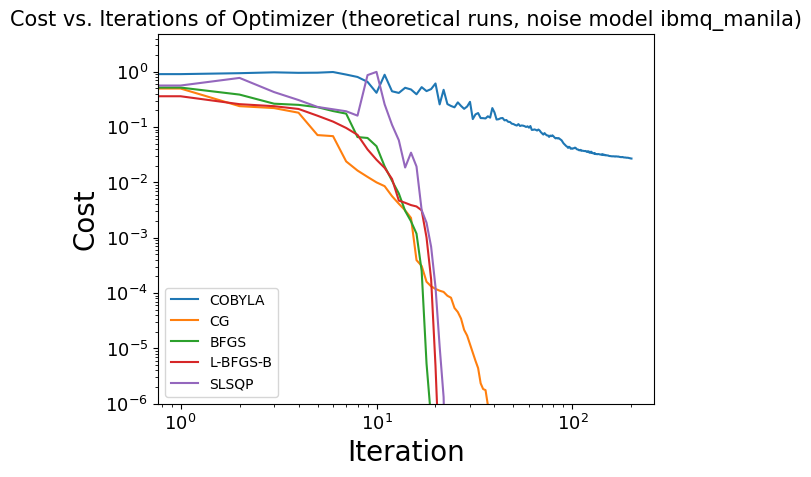

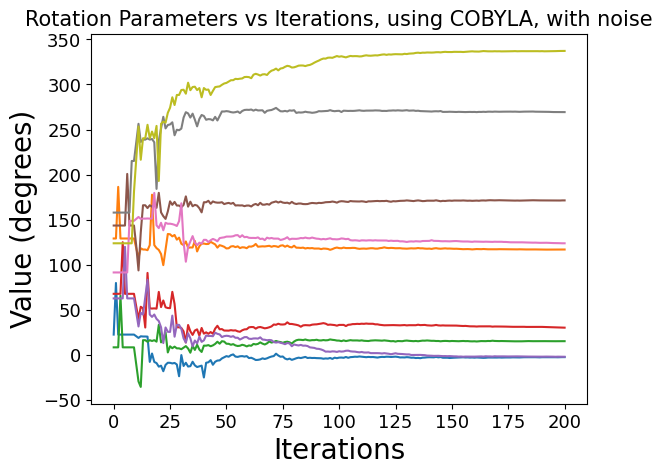

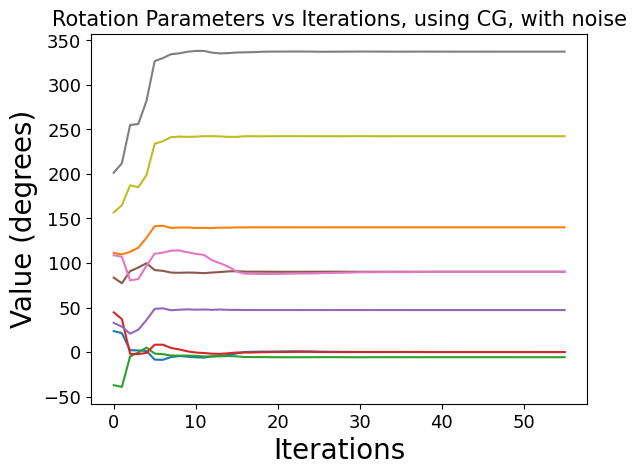

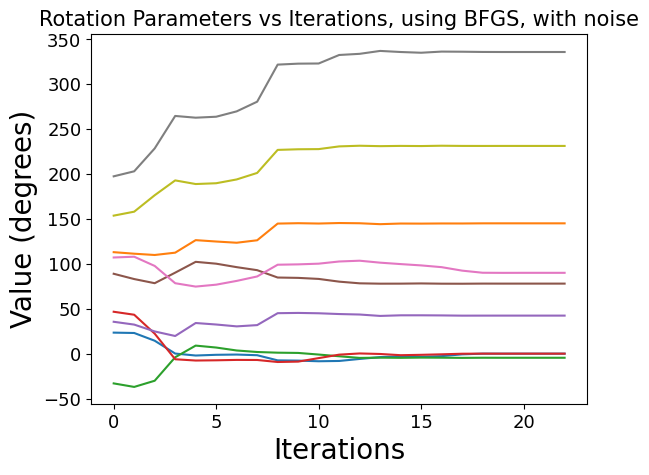

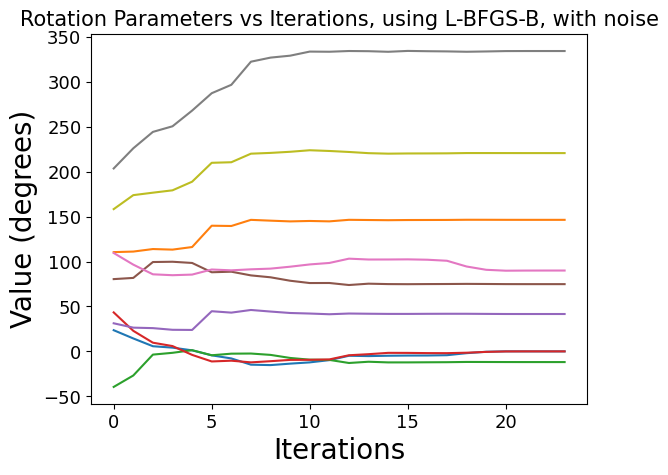

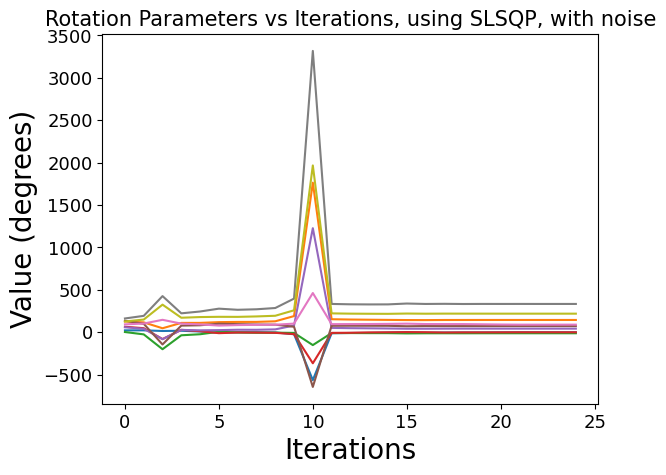

In [ ]:
#IND determines whether to print each graph individually
from math import pi
IND = False

optimizers = ["COBYLA", "CG", "BFGS", "L-BFGS-B", "SLSQP", ]
for i in range(len(optimizers)):
    plt.loglog(cost_sum[i]/opt_iter)
    if IND: 
        plt.ylim(math.pow(10,-6))
        plt.legend([optimizers[i]])
        plt.show()

plt.xlabel('Iteration',fontsize=20)
plt.ylabel('Cost',fontsize=20)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylim(math.pow(10,-6))
plt.legend(optimizers)
title = "Cost vs. Iterations of Optimizer (theoretical runs, " + ("noise model ibmq_manila)" if NOISE else "no noise)" )
plt.title(title, fontsize=15)
plt.savefig(title +".pdf", bbox_inches='tight')
# Seed:
print("Starting  with k = : " + str(k))
plt.show()

for j in range(len(optimizers)):
    for i in range(len(all_params[0][0])):
        plt.plot(list(map(lambda h: (180/pi)*h[i], all_params[j])))

    plt.xlabel("Iterations", fontsize=20)
    plt.ylabel("Value (degrees)", fontsize=20)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    title = "Rotation Parameters vs Iterations, using " + optimizers[j] + (", with noise" if NOISE else ", without noise")
    plt.title(title, fontsize=15)
    plt.savefig(title + ".pdf", bbox_inches='tight')
    plt.show()

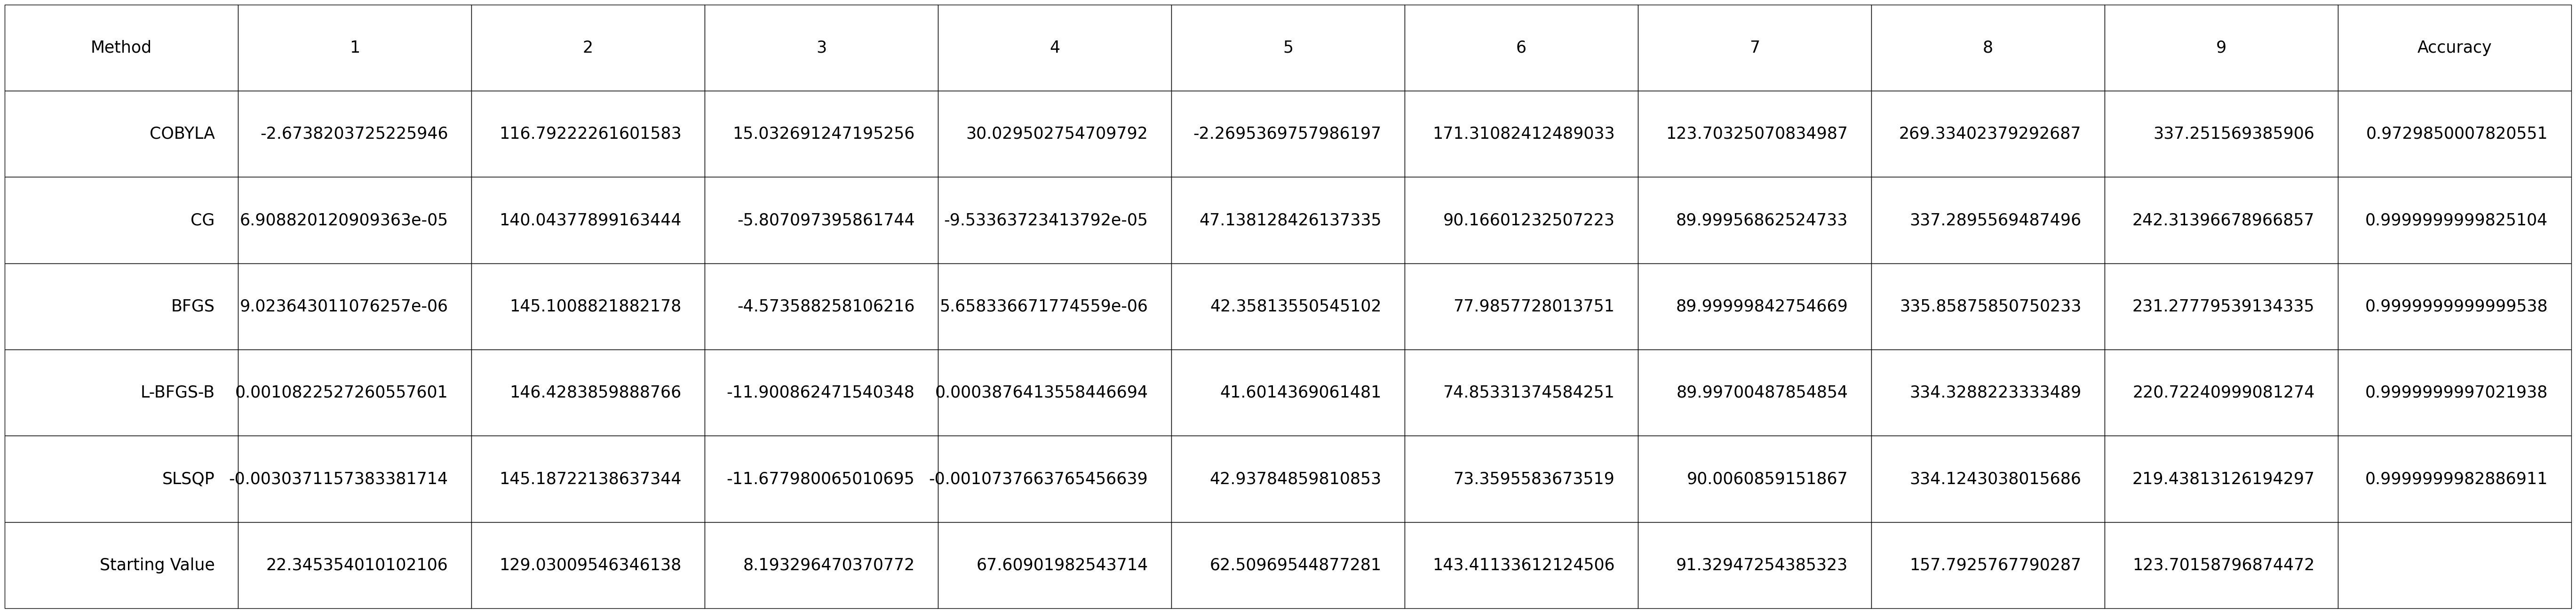

In [ ]:
import pandas as pd

all_params_table = []

cols = ["Method"]
cols += [str(x+1) for x in range(9)]
cols += ["Accuracy"]

for j in range(len(optimizers)):
    next_row = []
    next_row += [optimizers[j]]
    for e in all_params[j][len(all_params[j])-1]:
        next_row += [e*(180/pi)]
    next_row += [(accuracy[j]).real]
    all_params_table += [next_row]

next_row = ["Starting Value"]
next_row += list(map(lambda h: h*(180/pi), k))
next_row += [""]
all_params_table += [next_row]

fig, ax = plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')

df = pd.DataFrame(all_params_table, columns=cols)

table = ax.table(cellText=df.values, colLabels=df.columns, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(25)
table.scale(11,11)
plt.savefig("Final Parameters and Accuracy, per Optimization method" + (" (with noise)" if NOISE else " (without noise)") +".pdf", bbox_inches='tight')
plt.show()